In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

Query Date: 2016-08-23


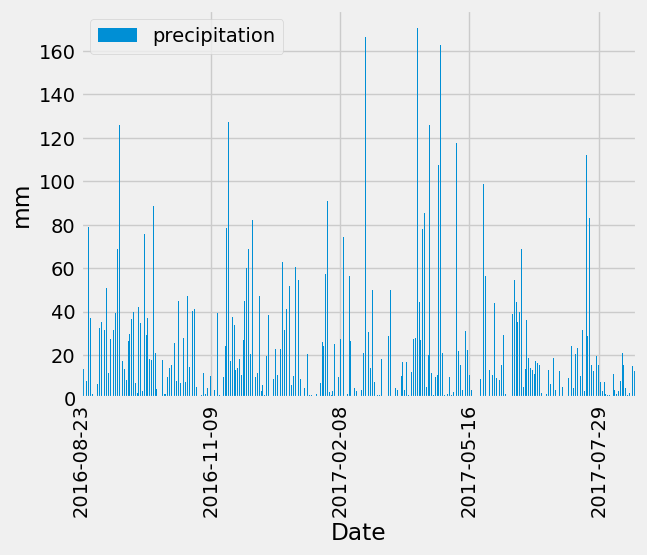

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print ("Query Date:", query_date)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['date','precipitation'])
precipitation_df.count()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('date')
precipitation_df.head(50)

precipitation_groupby_obj = precipitation_df.groupby('date')

precipitation_series = precipitation_groupby_obj['precipitation'].sum()

precipitation_plot_df = pd.DataFrame(precipitation_series)
precipitation_plot_df

## DO NOT CHANGE precipitation_df code above

precipitation_plot_df.head()
precipitation_plot_df = precipitation_plot_df.loc[precipitation_plot_df["precipitation"]>0]
precipitation_plot_df = precipitation_plot_df.loc[precipitation_plot_df["precipitation"]<175]
precipitation_plot_df = precipitation_plot_df.reset_index()
precipitation_plot_df.count()

# Use Pandas Plotting with Matplotlib to plot the data
# Reference: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis
figure1 = precipitation_plot_df.plot(kind = 'bar')
figure1.set_xticklabels(precipitation_plot_df['date'],rotation = 90)
figure1.set_ylabel('mm')
figure1.set_xlabel('Date')
figure1.set_xticks(range(0, len(precipitation_plot_df), 72))
plt.show()



In [11]:
precipitation_plot_df.count()

date             310
precipitation    310
dtype: int64

In [12]:
precipitation_plot_df.head(73)

,date,precipitation
0,2016-08-23,68.9
1,2016-08-25,13.6
2,2016-08-26,2.6
3,2016-08-27,8.1
4,2016-08-28,78.9
...,...,...
68,2016-11-05,11.5
69,2016-11-06,2.1
70,2016-11-07,4.6
71,2016-11-08,28.5


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Reference: https://www.statology.org/pandas-histogram-x-axis-range/
summary_statistics_series = precipitation_df['precipitation'].describe()
summary_statistics__df = pd.DataFrame(summary_statistics_series)
summary_statistics__df 


,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset    # Answer = 9
station_count = session.query(Measurement).group_by(Measurement.station).count()
print(station_count)

9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?) #.desc()
# List the stations and their counts in descending order.
# Reference: https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
# Reference: https://stackoverflow.com/questions/4186062/sqlalchemy-order-by-descending
from sqlalchemy import desc

sel = [Measurement.station,
      func.count(Measurement.station)]
results = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]
summary_stats1 = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.station).all()
summary_stats1

[(12.2, 29.4, 22.03582251082252)]

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram  #group_by(Measurement.tobs).\
from sqlalchemy import asc

sel = [Measurement.tobs
      ]
temp_frequency = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= query_date).all()
    

temp_frequency

[(25.0,),
 (25.0,),
 (26.7,),
 (26.7,),
 (23.9,),
 (22.8,),
 (25.6,),
 (25.0,),
 (25.6,),
 (26.7,),
 (26.7,),
 (25.6,),
 (25.6,),
 (25.6,),
 (22.8,),
 (23.3,),
 (26.7,),
 (26.1,),
 (25.0,),
 (26.7,),
 (24.4,),
 (26.1,),
 (23.9,),
 (26.1,),
 (25.6,),
 (26.1,),
 (25.6,),
 (25.6,),
 (24.4,),
 (23.3,),
 (25.0,),
 (25.6,),
 (26.1,),
 (26.1,),
 (25.0,),
 (26.7,),
 (25.6,),
 (25.6,),
 (25.6,),
 (25.0,),
 (26.1,),
 (26.1,),
 (26.1,),
 (26.1,),
 (23.9,),
 (24.4,),
 (22.8,),
 (22.2,),
 (21.7,),
 (25.0,),
 (26.1,),
 (25.6,),
 (26.1,),
 (25.0,),
 (26.1,),
 (25.0,),
 (25.6,),
 (25.6,),
 (25.6,),
 (25.6,),
 (25.0,),
 (23.3,),
 (23.9,),
 (24.4,),
 (22.8,),
 (24.4,),
 (23.3,),
 (25.0,),
 (24.4,),
 (24.4,),
 (23.3,),
 (23.9,),
 (23.9,),
 (23.9,),
 (23.9,),
 (21.7,),
 (17.2,),
 (21.1,),
 (20.0,),
 (19.4,),
 (25.0,),
 (23.3,),
 (25.0,),
 (24.4,),
 (24.4,),
 (23.9,),
 (24.4,),
 (23.9,),
 (22.8,),
 (23.9,),
 (22.8,),
 (23.9,),
 (23.3,),
 (23.9,),
 (23.3,),
 (23.9,),
 (22.8,),
 (23.9,),
 (22.8,),
 (22.8,),


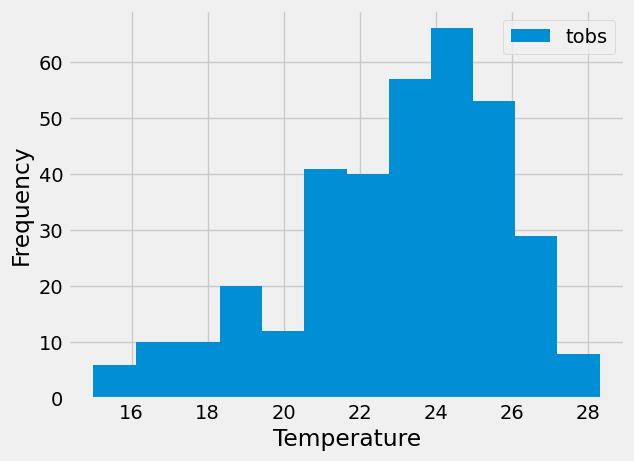

In [37]:
tobs_df = pd.DataFrame(temp_frequency, columns=['tobs'])
tobs_df.head()

# Reference: https://matplotlib.org/stable/gallery/statistics/histogram_histtypes.html#sphx-glr-gallery-statistics-histogram-histtypes-py
# Reference: https://www.geeksforgeeks.org/change-the-legend-position-in-matplotlib/
plt.hist(tobs_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()



# Close Session

In [38]:
# Close Session
session.close()
